In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('cleaned_data.csv')

In [4]:
df.describe()

,Open,High,Low,Close
count,7098.000000,7098.000000,7098.000000,7098.000000
mean,110.649592,111.101390,110.155538,110.644679
std,14.894489,14.980412,14.806835,14.894081
min,75.750000,75.973999,75.570000,75.739998
25%,104.180000,104.614250,103.712250,104.176752
50%,110.698498,111.100502,110.308498,110.708500
75%,119.260752,119.782247,118.720001,119.262251
max,151.645996,151.936996,151.240005,151.645996


In [6]:
df.set_index('Date', inplace=True)

# split train，validation, test set

In [7]:
#split the train, validation and test set
l = len(df)
split_point = int(0.6*l)
split_point2 = int(0.8*l)
train = df[:split_point]
validation = df[split_point: split_point2]
test = df[split_point2:]

In [8]:
len(train), len(validation), len(test)

(4258, 1420, 1420)

# The target: 3-days forward forecast 

In [9]:
y_train = train['Close'].pct_change(3).shift(-3)
y_train

Date
1996-10-29 19:00:00-05:00   -0.002627
1996-10-30 19:00:00-05:00    0.000613
1996-10-31 19:00:00-05:00    0.003965
1996-11-03 19:00:00-05:00    0.000615
1996-11-04 19:00:00-05:00   -0.021969
                               ...   
2013-02-17 19:00:00-05:00   -0.000661
2013-02-18 19:00:00-05:00   -0.005339
2013-02-19 19:00:00-05:00         NaN
2013-02-20 19:00:00-05:00         NaN
2013-02-21 19:00:00-05:00         NaN
Name: Close, Length: 4258, dtype: float64

# Characteristics of fx daily ohlc

In [15]:
from return_volatility import OHLCAnalyzer
analyzer = OHLCAnalyzer(train)
features_characteristics = analyzer.prepare_features()


In [16]:
features_characteristics.columns

Index(['forward_return_1', 'return_1', 'forward_return_3', 'return_3',
       'forward_return_5', 'return_5', 'forward_return_10', 'return_10',
       'volatility_5', 'volatility_10', 'volatility_20'],
      dtype='object')

# Augmented Dickey-Fuller test

# Using technical indicators to build features

In [12]:
from technical_indicators import TAFeatures
ta_indicators = TAFeatures(train)
ta_features = ta_indicators.get_all_indicators()

2.1.4


In [13]:
ta_features.columns

Index(['ADX', 'ADXR', 'APO', 'AROONOSC', 'BOP', 'CCI', 'MACD', 'MOM', 'RSI',
       'ULTOSC', 'DEMA', 'EMA', 'MA', 'NATR', 'TRANGE'],
      dtype='object')

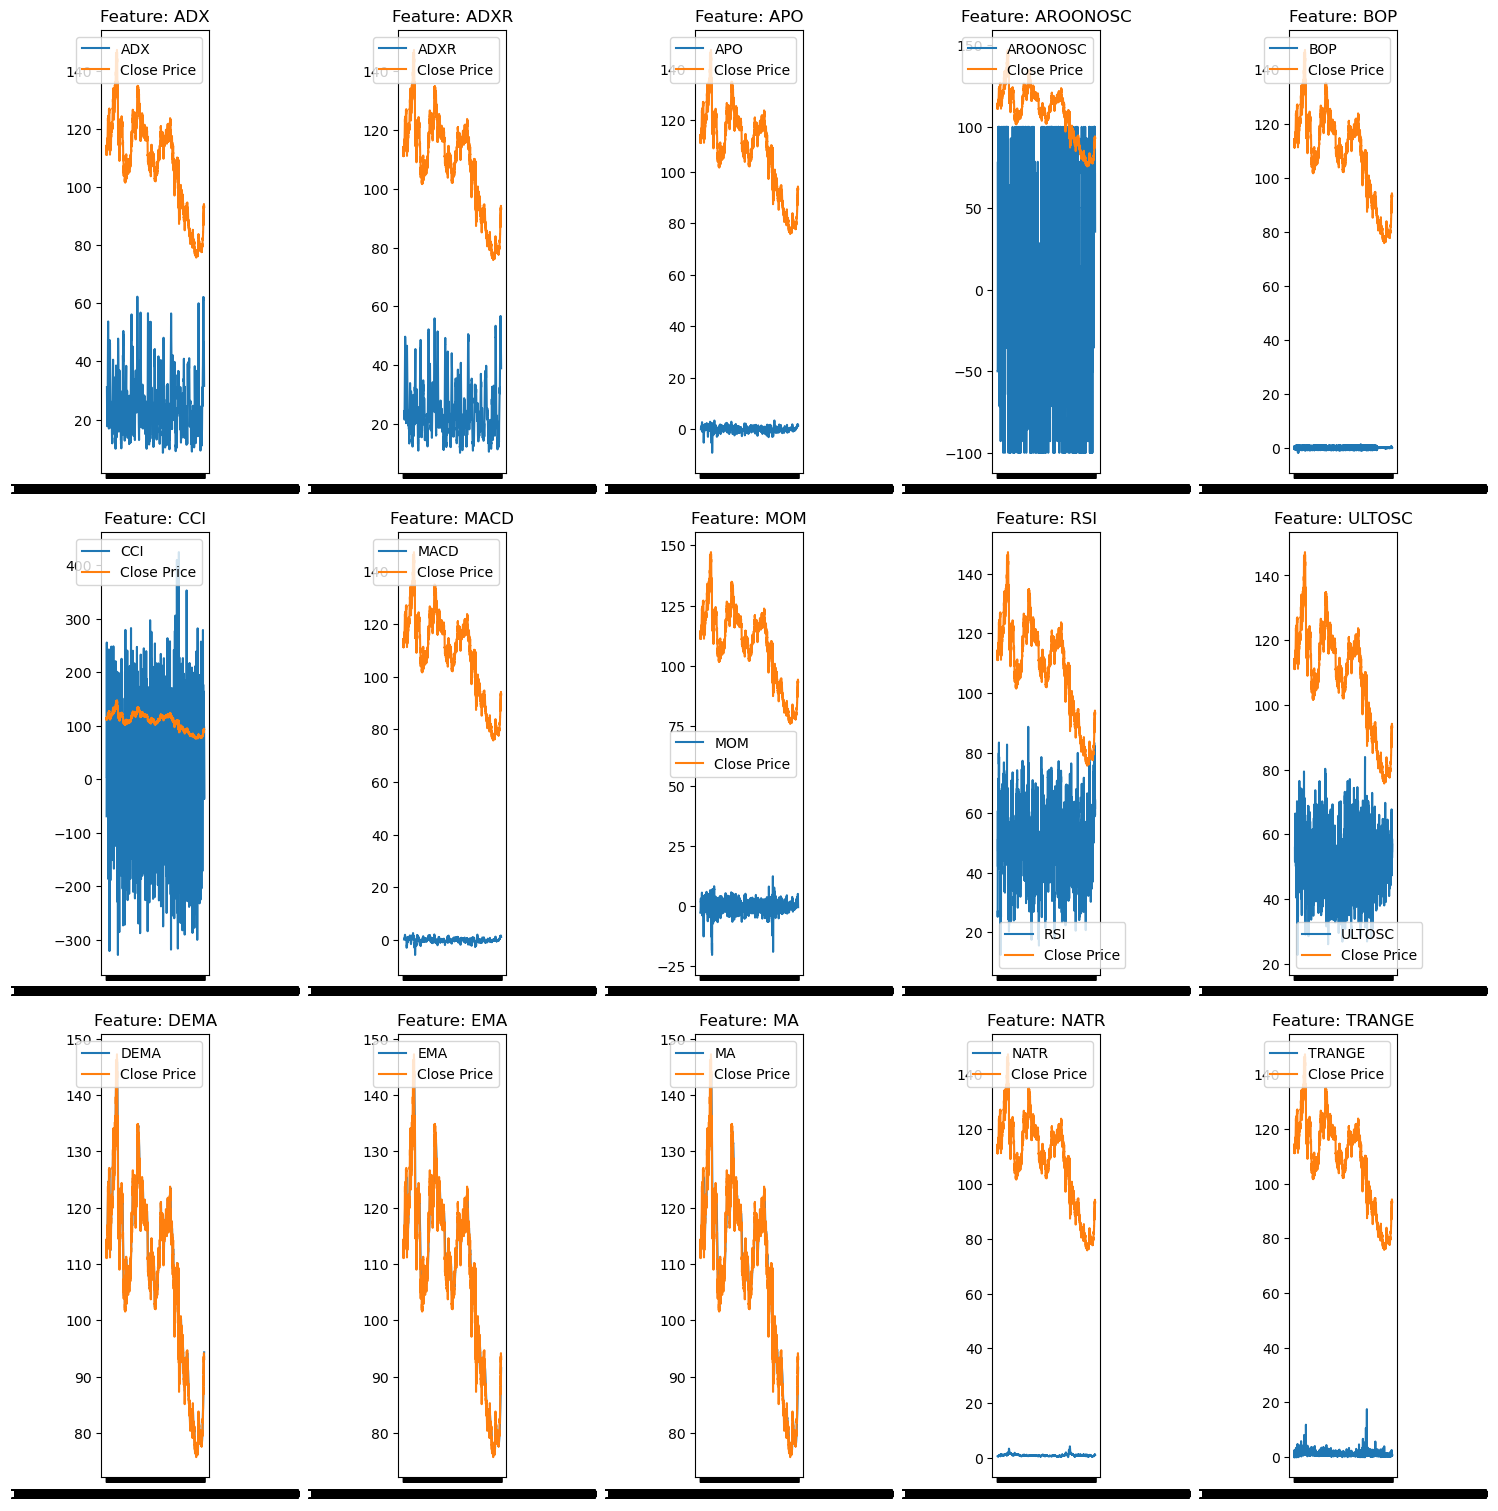

In [14]:

n_rows = 4
n_cols = 5

plt.figure(figsize=(15, 20))

for i, column in enumerate(ta_features.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(ta_features.index, ta_features[column], label=column)
    plt.plot(ta_features.index, train['Close'], label='Close Price')
    plt.title(f"Feature: {column}")
    plt.legend()

plt.tight_layout()
plt.show()

In [25]:
features = pd.concat([features_characteristics, ta_features],axis =1)
y_train = features['forward_return_3']
X_train = features.drop('forward_return_3', axis=1)
X_train.index = pd .to_datetime(X_train.index)

In [30]:
# Be careful in this step, in case that bringring in no consistence in the time series
X_train = X_train.dropna()
X_train



,forward_return_1,return_1,return_3,forward_return_5,return_5,forward_return_10,return_10,volatility_5,volatility_10,volatility_20,...,CCI,MACD,MOM,RSI,ULTOSC,DEMA,EMA,MA,NATR,TRANGE
Date,,,,,,,,,,,,,,,,,,,,,
1997-01-19 19:00:00-05:00,-0.000254,0.005029,0.009763,0.013739,0.012277,0.031719,0.019013,0.062334,0.060931,0.062880,...,187.897435,0.881815,2.200005,70.137756,60.483974,117.097036,115.473305,115.237333,0.781276,0.989998
1997-01-20 19:00:00-05:00,0.000424,-0.000254,0.011498,0.026468,0.008038,0.038853,0.023086,0.063102,0.052404,0.063008,...,150.059279,0.921713,2.659996,69.757766,59.642249,117.292802,115.628576,115.388333,0.775342,0.820000
1997-01-21 19:00:00-05:00,0.010769,0.000424,0.005199,0.026032,0.009934,0.047147,0.017954,0.058608,0.049897,0.063091,...,129.178332,0.946458,2.080002,70.048965,57.892512,117.472812,115.777055,115.556667,0.722684,0.050003
1997-01-22 19:00:00-05:00,-0.002936,0.010769,0.010940,0.021393,0.022825,0.038591,0.024847,0.072574,0.066980,0.071285,...,190.643989,1.056369,2.889999,76.292763,57.197512,117.790831,115.997890,115.759000,0.775971,1.870003
1997-01-23 19:00:00-05:00,0.005722,-0.002936,0.008229,0.020194,0.013041,0.036180,0.023598,0.085548,0.069345,0.073051,...,144.244489,1.102523,2.739997,71.847500,55.902811,118.031300,116.181897,115.925667,0.830846,1.800004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-03 19:00:00-05:00,-0.006651,0.011591,0.021809,-0.002533,0.017449,0.010262,0.028709,0.115658,0.160546,0.147874,...,160.687424,1.531339,2.588997,73.469638,58.418585,91.460161,88.651114,88.585566,1.232418,1.462997
2013-02-04 19:00:00-05:00,0.015377,-0.006651,0.012437,0.022115,0.018715,0.016245,0.028493,0.108093,0.160888,0.143675,...,128.189383,1.543436,2.553002,68.295756,47.356042,91.716213,88.877043,88.829333,1.259247,1.382996
2013-02-05 19:00:00-05:00,-0.001443,0.015377,0.020315,-0.002832,0.030620,0.001475,0.056942,0.135979,0.148448,0.147663,...,161.676459,1.648362,5.041001,72.998654,50.093479,92.119050,89.179814,89.115000,1.294496,1.872002


In [36]:
from statsmodels.tsa.stattools import adfuller

non_stationary_columns = []

for column in X_train.columns:
    series = X_train[column].values
    result = adfuller(series)
    print('==========================')
    print(f'Column:{column}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' %(key, value))
    
    if result[0] > result[4]['1%'] or result[0] >result[4]['5%'] or result[0] > result[4]['10%']:
        non_stationary_columns.append(column)
        X_train[column] = X_train[column].diff(periods=5)

non_stationary_columns





Column:forward_return_1
ADF Statistic: -11.917866
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_1
ADF Statistic: -11.843375
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_3
ADF Statistic: -11.250627
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:forward_return_5
ADF Statistic: -10.741139
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_5
ADF Statistic: -10.667471
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:forward_return_10
ADF Statistic: -8.648719
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_10
ADF Statistic: -8.533184
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:volatility_5
ADF Statistic: -7.666837
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:volatility_10
ADF Statistic: -6.627296
p-value: 0.0000

['DEMA', 'EMA', 'MA']

In [39]:
X_train = X_train.dropna()

In [40]:
for i in non_stationary_columns:
    result = adfuller(X_train[i].values)
    print('==========================')
    print(f'Column:{column}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' %(key, value))

Column:TRANGE
ADF Statistic: -9.025246
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:TRANGE
ADF Statistic: -7.541858
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:TRANGE
ADF Statistic: -6.896149
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


All features are stationary now.

In [42]:
X_train.describe()

,forward_return_1,return_1,return_3,forward_return_5,return_5,forward_return_10,return_10,volatility_5,volatility_10,volatility_20,...,CCI,MACD,MOM,RSI,ULTOSC,DEMA,EMA,MA,NATR,TRANGE
count,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,...,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000
mean,-0.000027,-0.000023,-0.000092,-0.000186,-0.000162,-0.000403,-0.000350,0.101746,0.106321,0.109556,...,2.221504,-0.044776,-0.060956,50.095995,52.273747,-0.030380,-0.031821,-0.031625,1.036339,1.123035
std,0.008278,0.008276,0.012519,0.015716,0.015730,0.021464,0.021521,0.089877,0.081001,0.074330,...,110.069638,0.867532,2.440459,12.128894,8.840821,0.998497,0.662242,0.672940,0.383648,0.828033
min,-0.155044,-0.155044,-0.162120,-0.171549,-0.171549,-0.174661,-0.174661,0.000000,0.000000,0.034007,...,-328.509026,-5.655455,-20.370003,12.408588,22.772369,-8.118021,-4.837316,-3.639000,0.351821,0.000000
25%,-0.003762,-0.003758,-0.006636,-0.008773,-0.008773,-0.013103,-0.013103,0.061114,0.069881,0.075566,...,-87.052390,-0.509024,-1.367996,41.540461,46.208383,-0.557236,-0.385644,-0.393333,0.810697,0.669998
50%,0.000000,0.000000,0.000171,0.000276,0.000281,0.000286,0.000301,0.086897,0.090738,0.095686,...,3.464787,-0.021970,0.029999,49.597916,52.107733,0.007510,-0.013704,-0.011766,0.958295,0.970001
75%,0.003891,0.003899,0.007159,0.009285,0.009313,0.013120,0.013168,0.119456,0.120885,0.123907,...,91.102312,0.489261,1.462998,58.485602,58.405222,0.604257,0.382958,0.397200,1.162745,1.349999
max,0.176902,0.176902,0.172858,0.172858,0.172858,0.127697,0.127697,1.871179,1.262333,0.882852,...,424.229310,2.648188,12.369995,88.756150,83.928955,3.181875,2.107158,1.870999,4.281629,17.529998


## clustering test

In [84]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=6, min_samples=2).fit(X_train.T)
labels = clustering.labels_
unique_labels = np.unique(labels)
unique_labels

array([-1,  0,  1])

In [87]:
factors = X_train.columns
factor_to_cluster = dict(zip(factors, labels))

clusters = {}
for factor, cluster in factor_to_cluster.items():
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(factor)

for cluster, factors in clusters.items():
    print(f"Cluster {cluster}: {factors}")

Cluster 0: ['forward_return_1', 'return_1', 'return_3', 'forward_return_5', 'return_5', 'forward_return_10', 'return_10']
Cluster 1: ['volatility_5', 'volatility_10', 'volatility_20']
Cluster -1: ['ADX', 'ADXR', 'APO', 'AROONOSC', 'BOP', 'CCI', 'MACD', 'MOM', 'RSI', 'ULTOSC', 'DEMA', 'EMA', 'MA', 'NATR', 'TRANGE']


Classification can help identify which factors are more important.

## Anomaly Detection

In [94]:
import scipy.stats as stats

for column in X_train.columns:
    ks_test = stats.kstest(X_train[column], 'norm')
    print(f"Kolmogorov-Smirnov Test for {column}:{ks_test}")

Kolmogorov-Smirnov Test for forward_return_1:KstestResult(statistic=0.4867118666814536, pvalue=0.0, statistic_location=0.023727350755351928, statistic_sign=1)
Kolmogorov-Smirnov Test for return_1:KstestResult(statistic=0.4867118666814536, pvalue=0.0, statistic_location=0.023727350755351928, statistic_sign=1)
Kolmogorov-Smirnov Test for return_3:KstestResult(statistic=0.4827029259035628, pvalue=0.0, statistic_location=0.03497909137281141, statistic_sign=1)
Kolmogorov-Smirnov Test for forward_return_5:KstestResult(statistic=0.47969717549360547, pvalue=0.0, statistic_location=0.0467159326994937, statistic_sign=1)
Kolmogorov-Smirnov Test for return_5:KstestResult(statistic=0.47969717549360547, pvalue=0.0, statistic_location=0.0467159326994937, statistic_sign=1)
Kolmogorov-Smirnov Test for forward_return_10:KstestResult(statistic=0.4744591712247974, pvalue=0.0, statistic_location=0.051466011617202545, statistic_sign=1)
Kolmogorov-Smirnov Test for return_10:KstestResult(statistic=0.474459171

Here we can see, except APO、DEMA、EMA、MA, almost all the features are not normal distribution. Hence, we can not use 3-sigma method to discard anomalies.

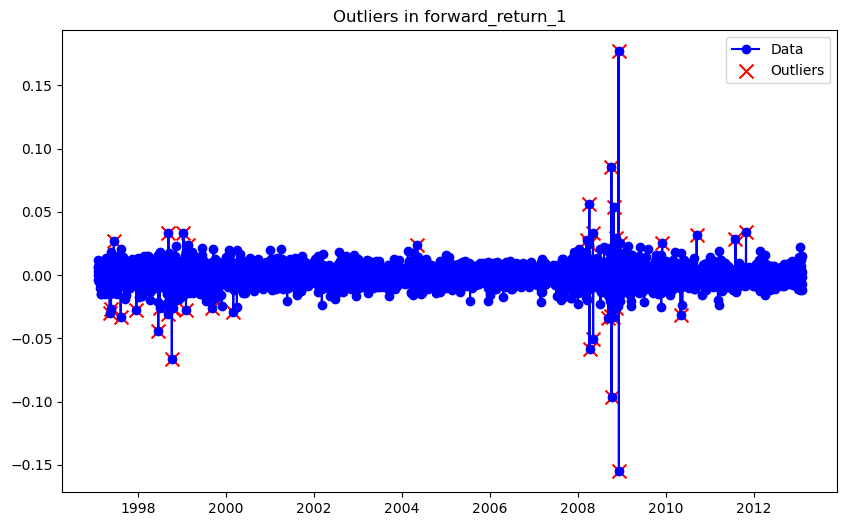

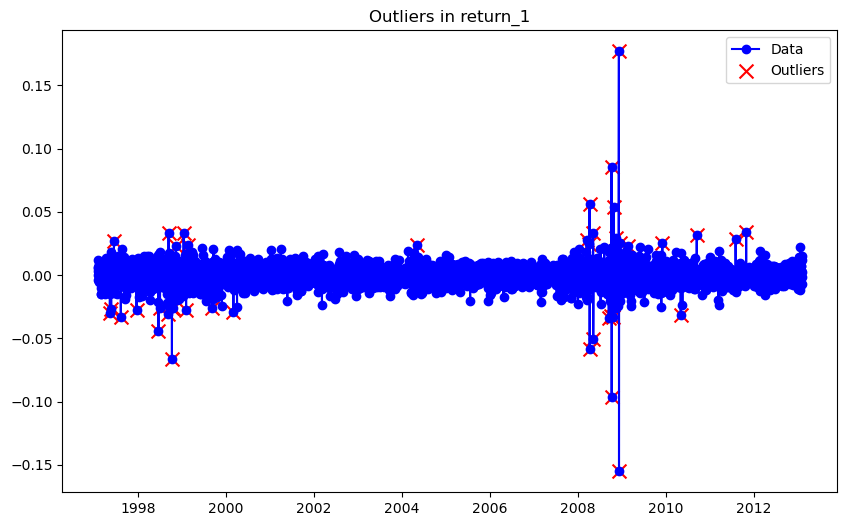

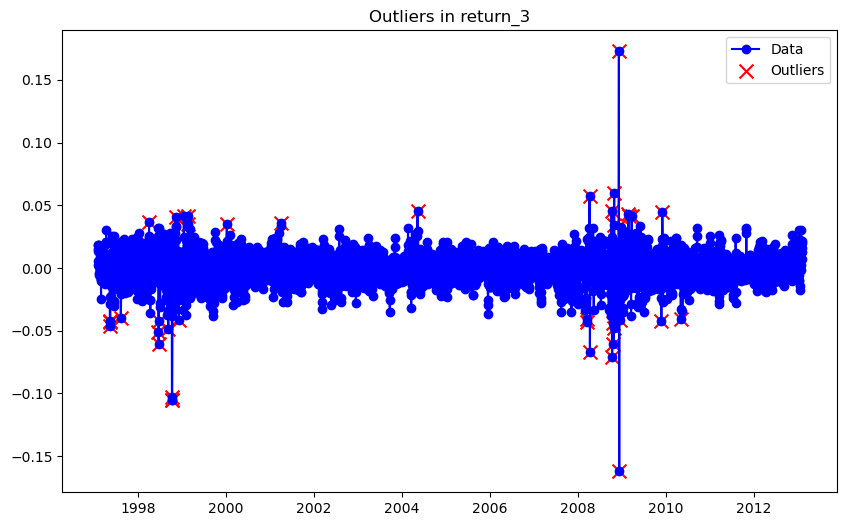

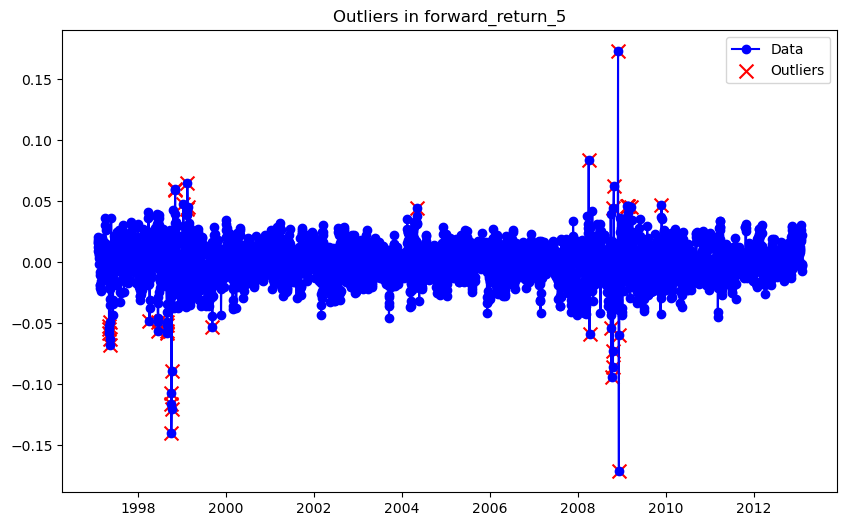

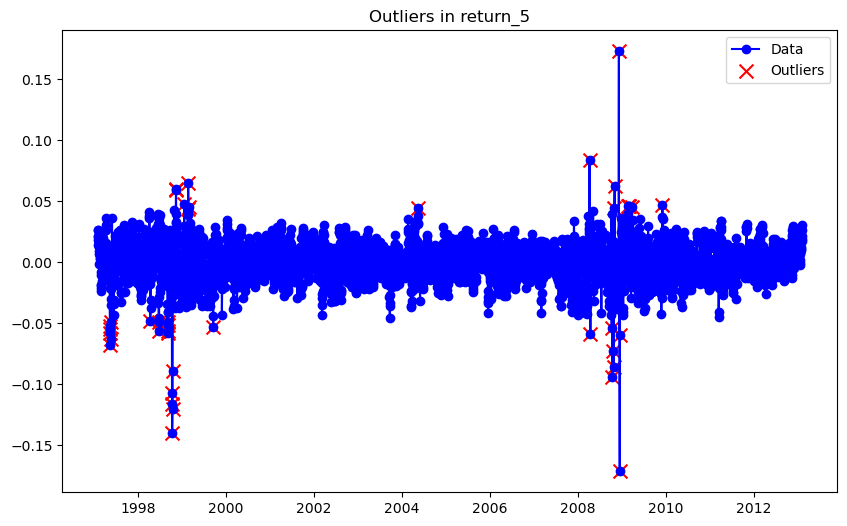

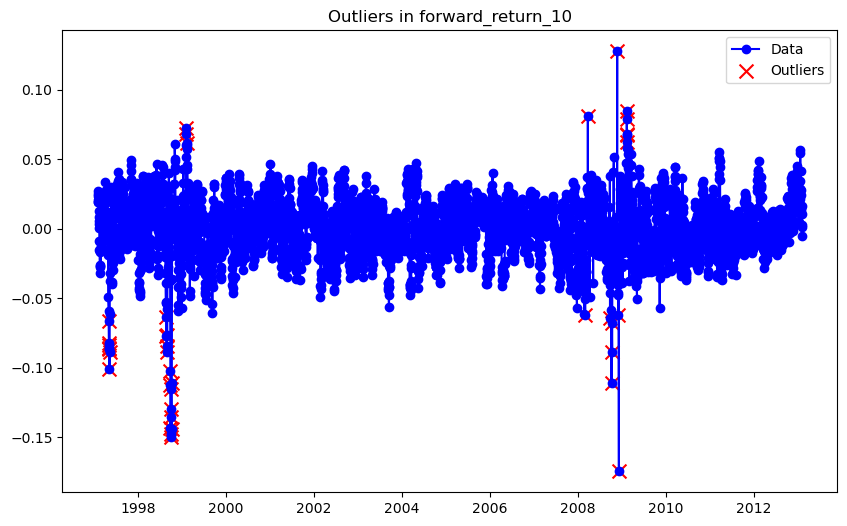

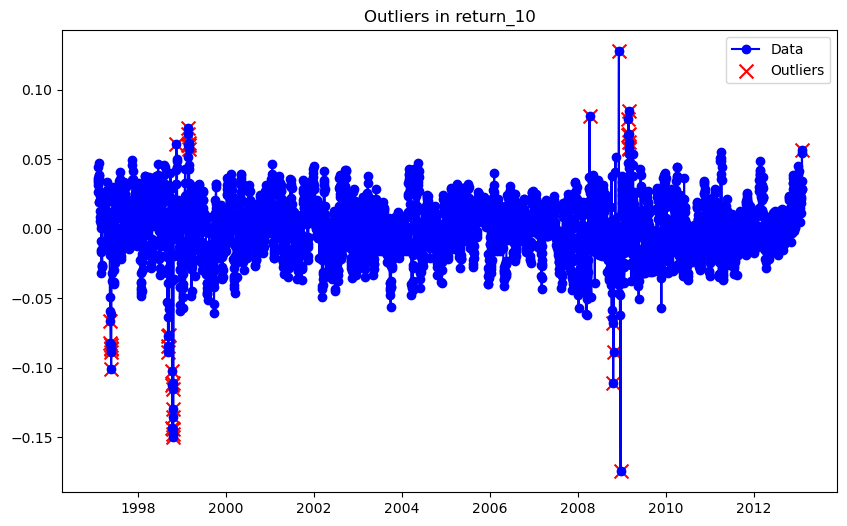

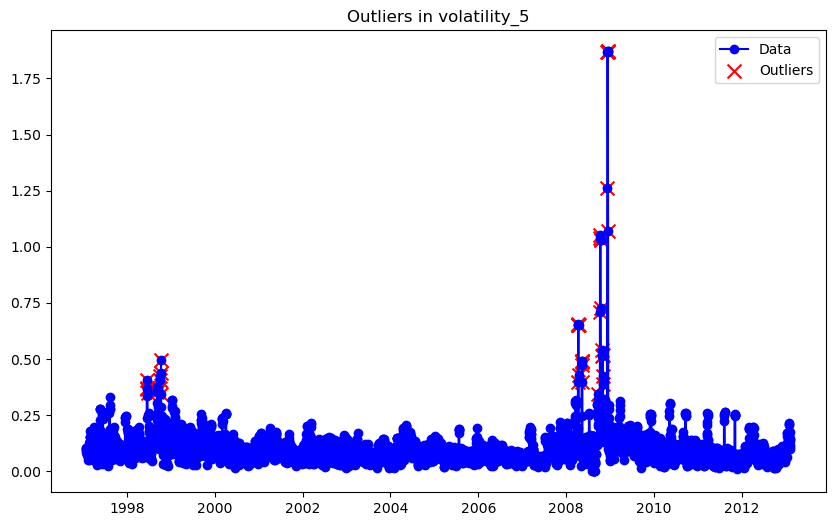

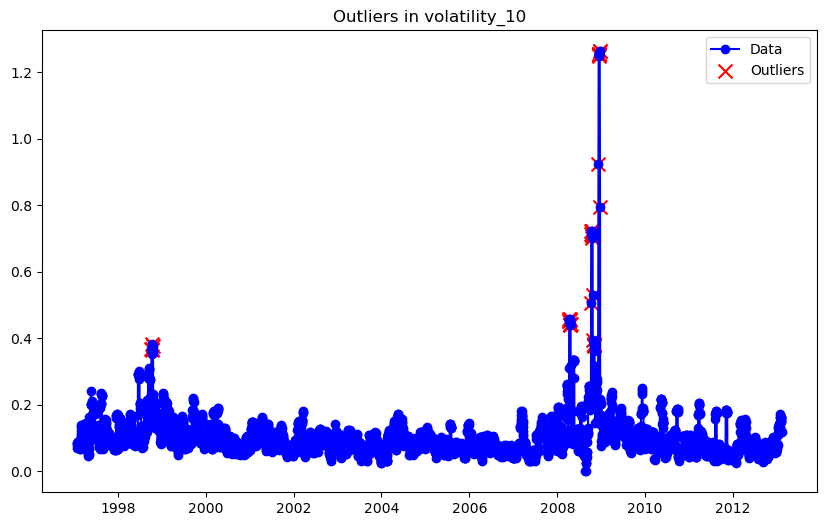

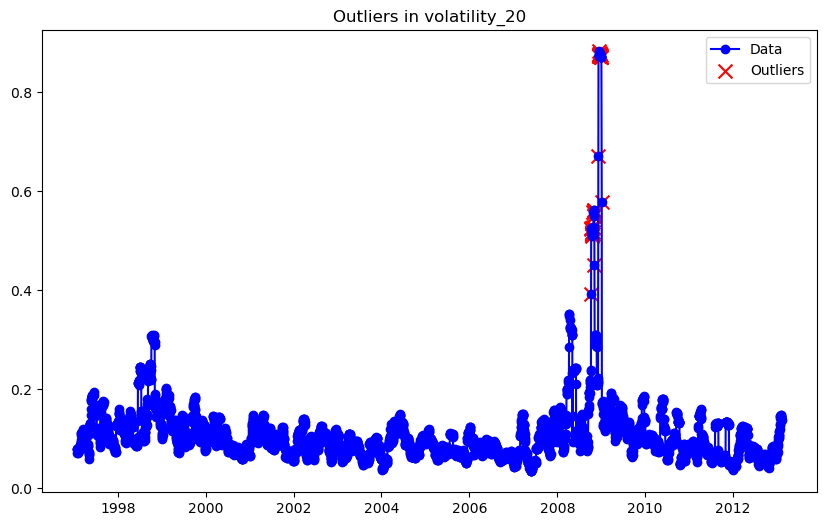

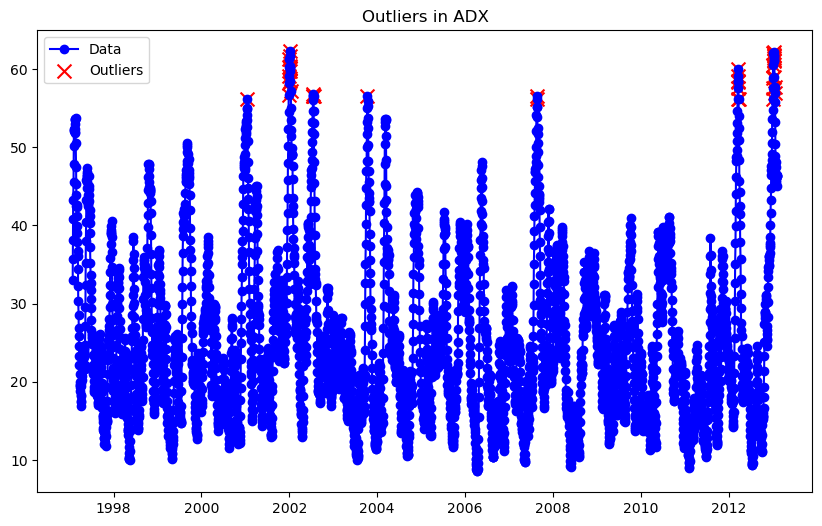

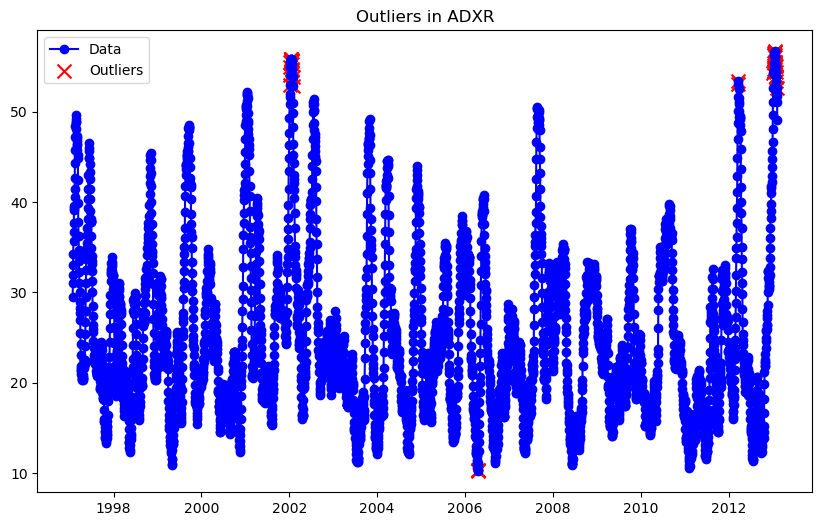

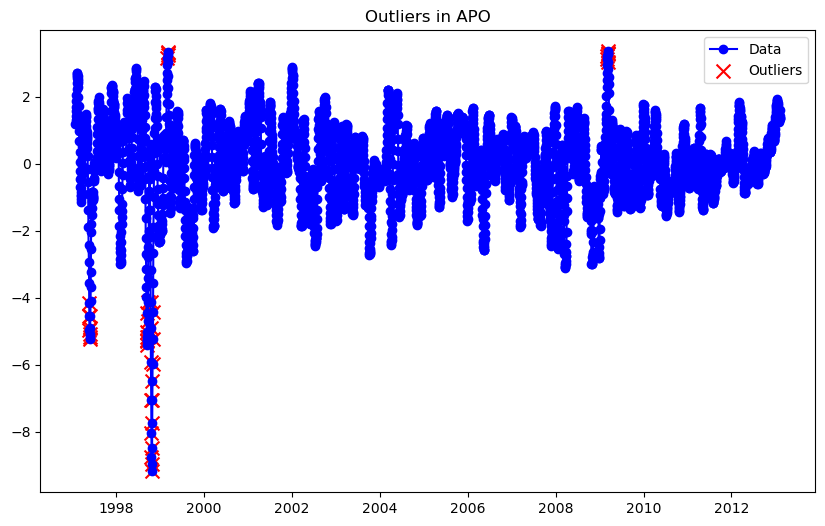

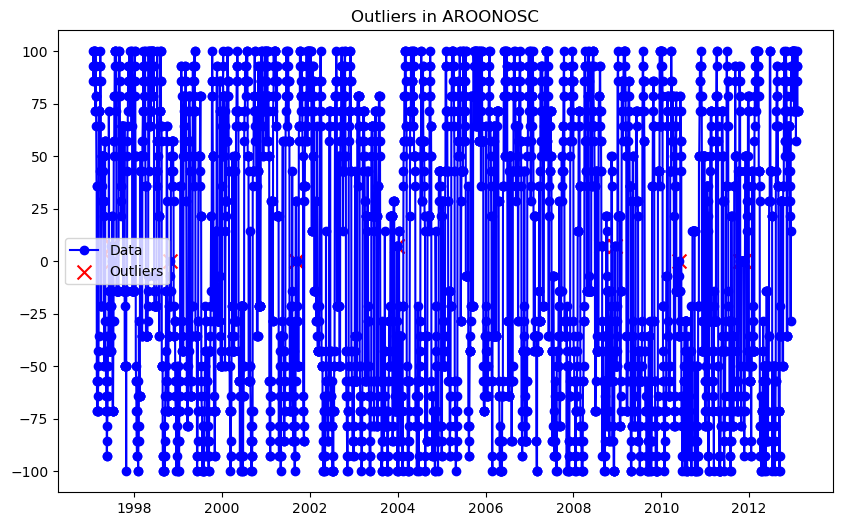

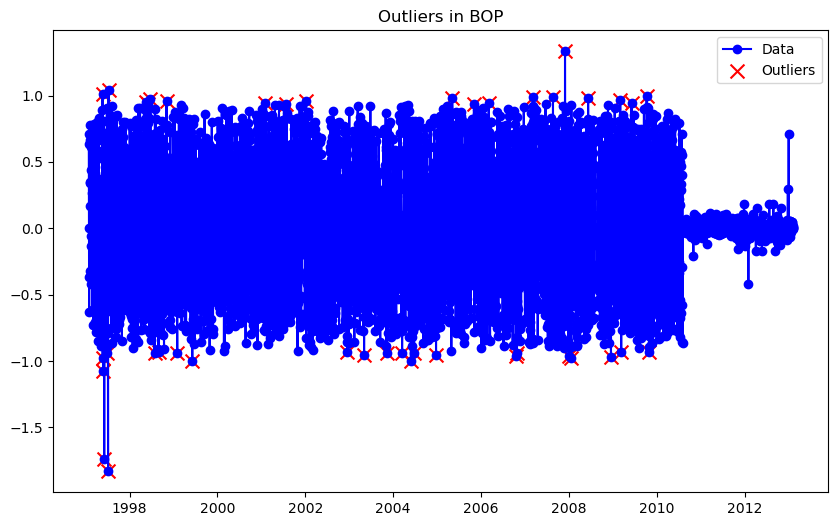

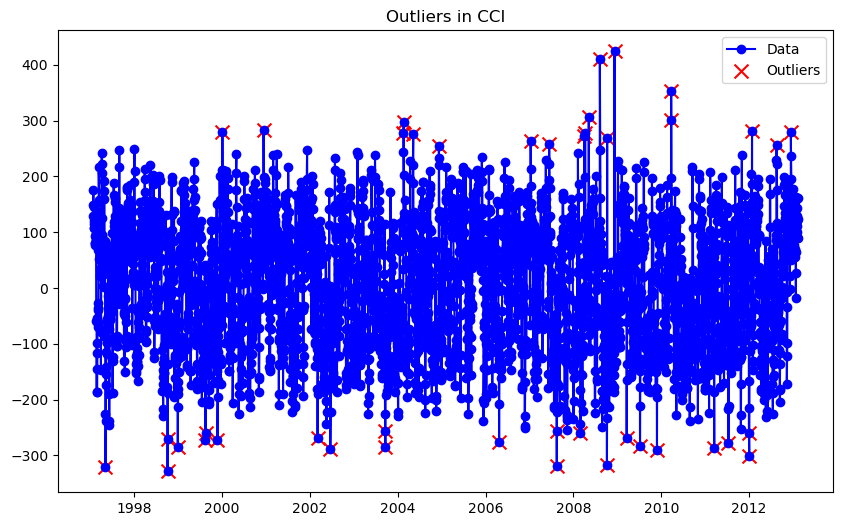

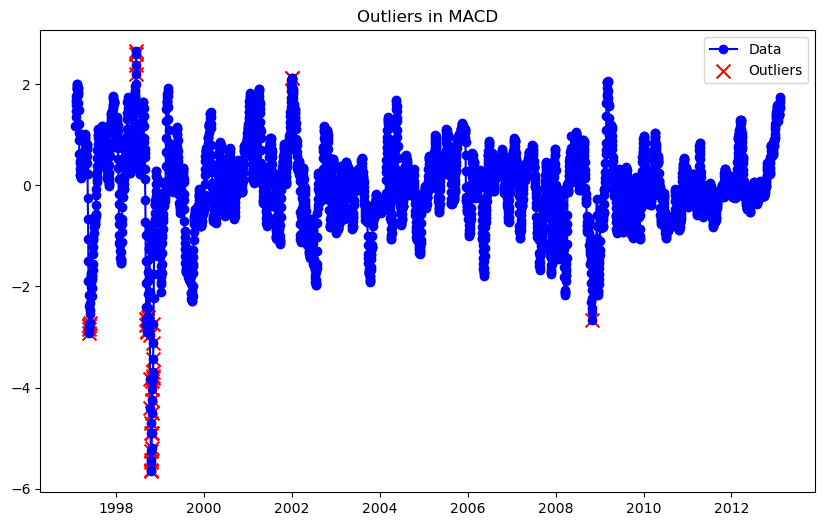

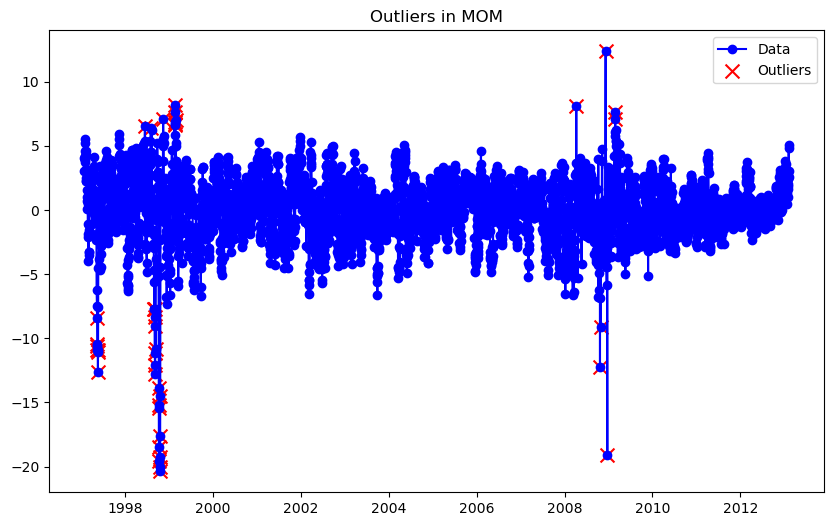

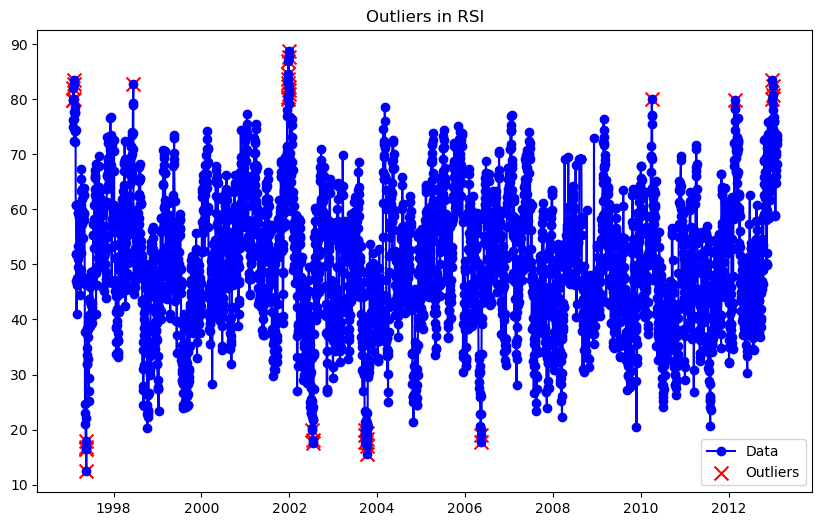

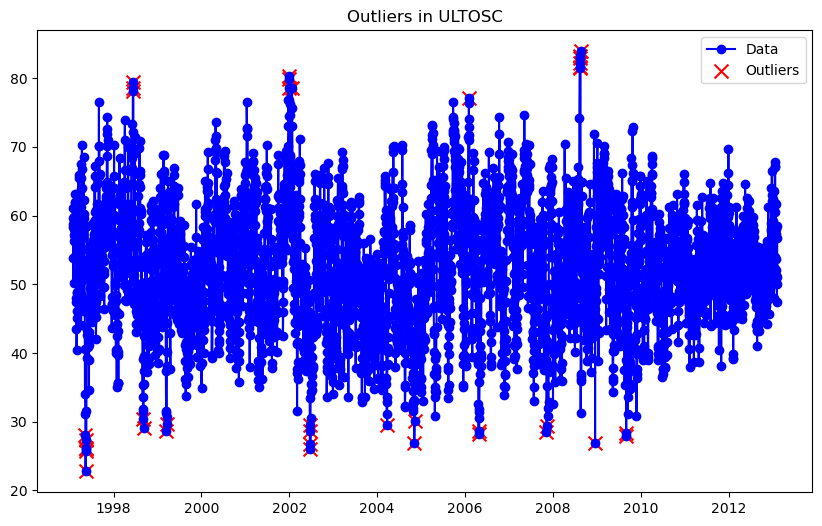

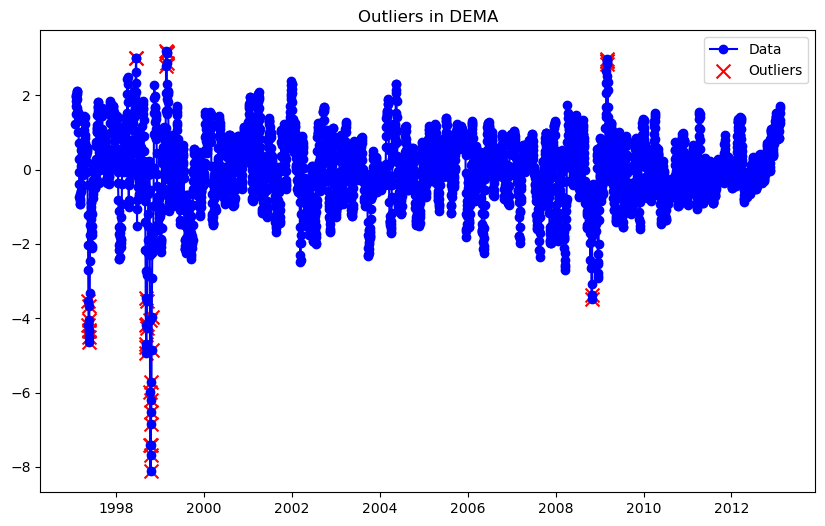

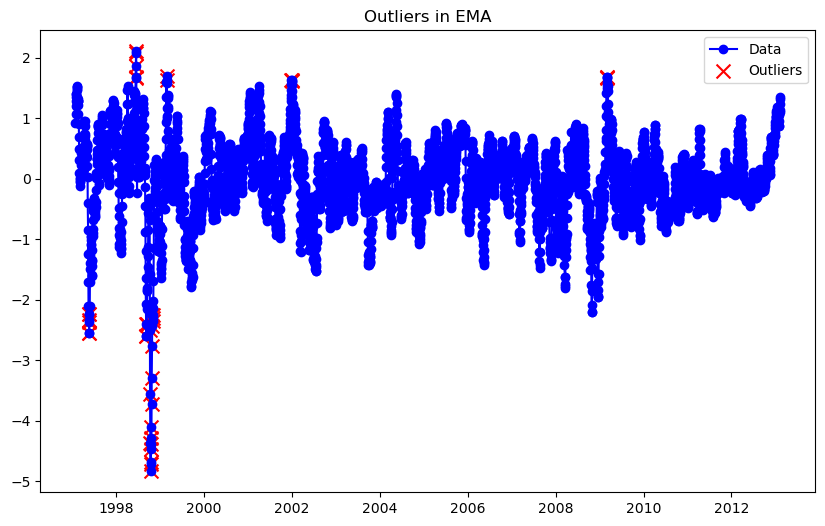

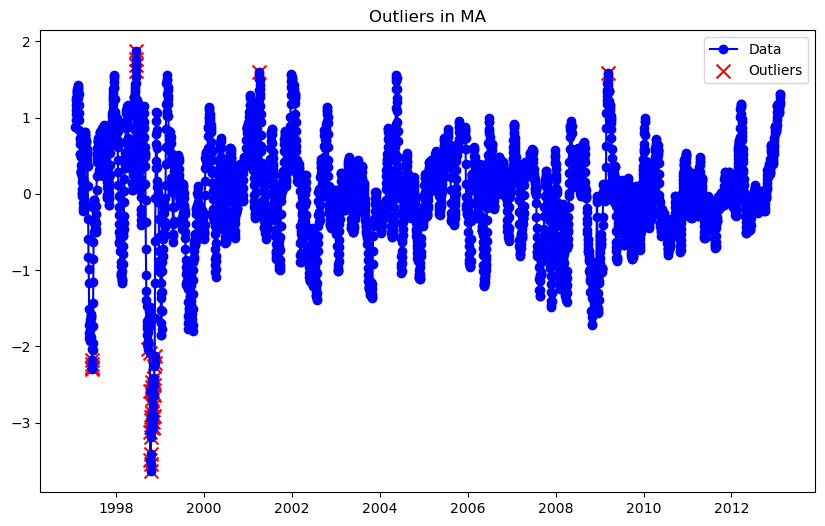

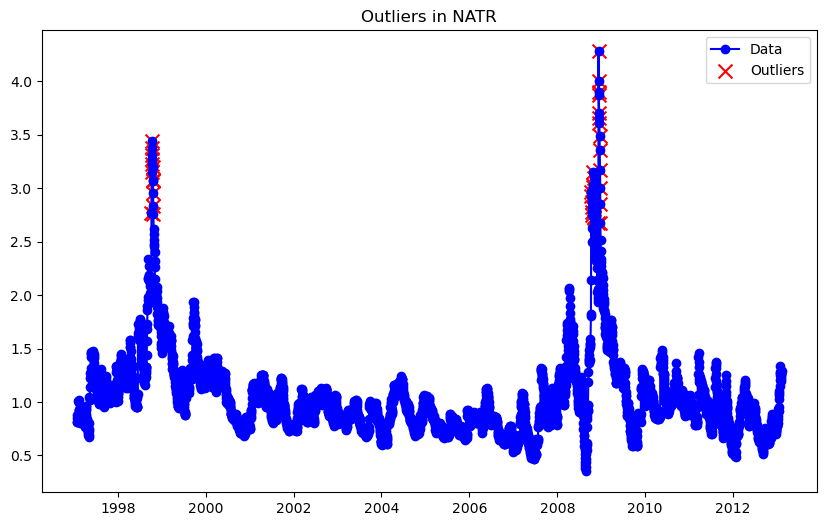

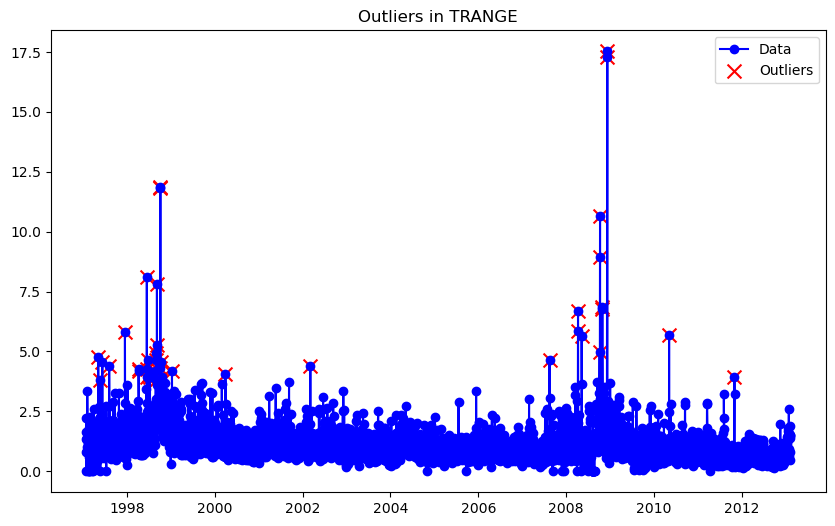

In [102]:
from sklearn.ensemble import IsolationForest

for column in X_train.columns:
    data = X_train[column]

    iso = IsolationForest(contamination=0.01)
    preds = iso.fit_predict(data.values.reshape(-1, 1))
    outliers = preds == -1

    plt.figure(figsize=(10, 6))
    plt.plot(X_train.index, data, label='Data', color='blue', marker='o')
    plt.scatter(X_train.index[outliers], data[outliers], color='red', marker='x', label='Outliers', s=100)
    plt.title(f"Outliers in {column}")
    plt.legend()
    plt.show()

    median = data.median()
    data[outliers] = median

First, set the outlier proportion to 0.01 uniformly, and then use median imputation to handle outliers.

## Feature selection

In [112]:
#To build a weighted least squared model to check the importance of very features
X_train.index = pd.to_datetime(X_train.index, utc=True)
y_train.index = pd.to_datetime(y_train.index, utc=True)

y_train = y_train[X_train.index]



correlation heatmap

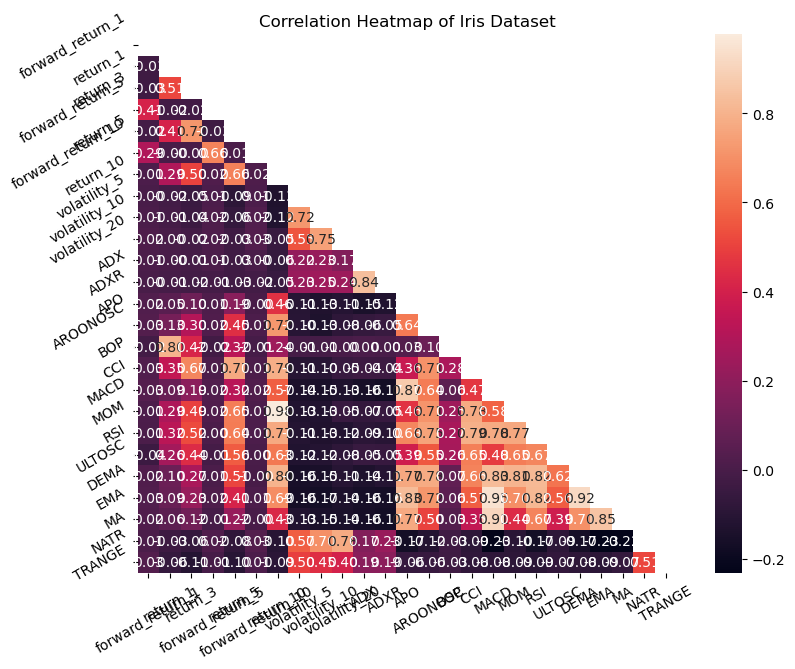

In [129]:
corr_matrix = X_train.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10,7))
plt.title('Correlation Heatmap of Iris Dataset')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black', mask=mask)
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [138]:
corr_matrix = X_train.corr()

# 创建上三角形矩阵，将下三角部分填充为NaN
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 查找相关性大于0.9的特征列索引
to_drop = [column for column in range(len(corr_matrix.columns)) if any(corr_matrix.iloc[column, column+1:] > 0.9)]
print(to_drop)

to_drop_columns = [X_train.columns[i] for i in to_drop]
X_train = X_train.drop(columns=to_drop_columns)

selected_features = X_train.columns




[]


In [123]:
import statsmodels.api as sm

weights = np.ones(X_train.shape[0])
model = sm.WLS(y_train, sm.add_constant(X_train), weights=weights)
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:       forward_return_3   R-squared:                       0.479
Model:                            WLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     153.1
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:27:28   Log-Likelihood:                 13762.
No. Observations:                4185   AIC:                        -2.747e+04
Df Residuals:                    4159   BIC:                        -2.731e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0050      0.00

Multicolinearity exists.

correlations = X_train.corrwith(y_train)
correlations_abs = correlations.abs().sort_values(ascending=False)
correlations_abs

In [124]:
correlations = X_train.corrwith(y_train)
correlations_abs = correlations.abs().sort_values(ascending=False)
correlations_abs

forward_return_5     0.640966
forward_return_1     0.485512
forward_return_10    0.484983
ULTOSC               0.027711
return_5             0.026666
return_1             0.023664
MACD                 0.023149
return_3             0.019295
CCI                  0.011737
EMA                  0.010497
volatility_10        0.010242
ADXR                 0.009481
RSI                  0.008399
AROONOSC             0.008301
volatility_20        0.007981
NATR                 0.007219
BOP                  0.006953
volatility_5         0.006339
ADX                  0.004071
MA                   0.003551
APO                  0.003442
TRANGE               0.003323
MOM                  0.000494
DEMA                 0.000483
return_10            0.000341
dtype: float64

In [140]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(considered_features,df):
    
    X = df[considered_features]
    X['intercept'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

selected_features = list(selected_features)
compute_vif(selected_features, X_train).sort_values('VIF', ascending=False)



,Variable,VIF
18,EMA,11.336246
16,RSI,7.530541
14,CCI,6.028434
19,MA,4.899911
11,APO,4.381873
15,MOM,4.229715
12,AROONOSC,3.672837
10,ADXR,3.534902
7,volatility_10,3.496151
9,ADX,3.470480


In [144]:
selected_features = list(selected_features)
selected_features.remove('EMA')
compute_vif(selected_features, X_train)

,Variable,VIF
0,forward_return_1,1.219762
1,return_1,3.174321
2,return_3,2.716089
3,forward_return_5,1.977154
4,return_5,3.383208
5,forward_return_10,1.793751
6,volatility_5,2.298354
7,volatility_10,3.486187
8,volatility_20,3.326123
9,ADX,3.468391


Since there are no VIFs greater than 10, it indicates that there is no significant multicollinearity.

In [146]:
X_train = X_train[selected_features]

# At this stage, the feature engineering for the training set is completed.

# To build the validation set an test set

In [149]:

analyzer = OHLCAnalyzer(validation)
features_characteristics = analyzer.prepare_features()
ta_indicators = TAFeatures(validation)
ta_features = ta_indicators.get_all_indicators()

features = pd.concat([features_characteristics, ta_features],axis =1)
y_validation = features['forward_return_3']
X_validation = features.drop('forward_return_3', axis=1)
X_validation.index = pd .to_datetime(X_validation.index)

X_validation = X_validation.dropna()
X_validation = X_validation[selected_features]

y_validation = y_validation.reindex(X_validation.index)


2.1.4


In [153]:
analyzer = OHLCAnalyzer(test)
features_characteristics = analyzer.prepare_features()
ta_indicators = TAFeatures(test)
ta_features = ta_indicators.get_all_indicators()

features = pd.concat([features_characteristics, ta_features],axis =1)
y_test = features['forward_return_3']
X_test = features.drop('forward_return_3', axis=1)
X_test.index = pd .to_datetime(X_test.index)

X_test = X_test.dropna()
X_test = X_test[selected_features]

y_test = y_test.reindex(X_test.index)

2.1.4


In [154]:
datasets = [X_train, y_train, X_validation, y_validation, X_test, y_test]
file_names = ['train_set.csv', 'train_labels.csv', 'validation_set.csv', 'validation_labels.csv', 'test_set.csv', 'test_labels.csv']

for i in range(len(file_names)):
    file_names[i] = file_names[i].replace('_labels', '')

for i in range(len(datasets)):
    combined_data = pd.concat([datasets[i-1], datasets[i]], axis=1)
    combined_data.to_csv(file_names[i], index=False)